# Autonomous Underwater Vehicle Fault Diagnosis

## Model training using Mcfly AutoML

Ji, Daxiong (2021), “Autonomous Underwater Vehicle Fault Diagnosis Dataset”, Mendeley Data, V1, doi: 10.17632/7rp2pmr6mx.1

Dataset source: https://data.mendeley.com/datasets/7rp2pmr6mx/1

## Data preparation

In [63]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(42)
SEED=42

In [34]:
data_path = "../data/autonomous-uboot/preprocessed"

# Load X_train
X_train = pd.read_parquet(os.path.join(data_path, "features-train.parquet"))

# Convert the dataframes into numpy arrays
X_train = convert_to(X_train, to_type="numpy3D")

# Swap axes so that Mcfly models can consume the input data
X_train = np.swapaxes(X_train, 1, 2)

# Same previous steps for the test dataset
X_test = pd.read_parquet(os.path.join(data_path, "features-test.parquet"))
X_test = convert_to(X_test, to_type="numpy3D")
X_test = np.swapaxes(X_test, 1, 2)

# Load the labels
y_train = pd.read_csv(os.path.join(data_path, "labels-train.csv"))
y_train = y_train["label"].values

y_test = pd.read_csv(os.path.join(data_path, "labels-test.csv"))
y_test = y_test["label"].values

# Encode labels using OneHotEncoder
ohe = OneHotEncoder()
ohe = ohe.fit(y_train.reshape(-1, 1))

y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((975, 180, 16), (245, 180, 16), (975, 5), (245, 5))

In [35]:
# Validation dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.20, 
    random_state=SEED,
    shuffle=True, 
    stratify=y_train
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((780, 180, 16), (195, 180, 16), (780, 5), (195, 5))

In [36]:
from collections import Counter

print("y_train:", Counter(np.argmax(y_train, axis=1)))
print("y_val:", Counter(np.argmax(y_val, axis=1)))
print("y_test:", Counter(np.argmax(y_test, axis=1)))

y_train: Counter({0: 171, 2: 170, 4: 166, 3: 159, 1: 114})
y_val: Counter({2: 43, 0: 43, 4: 41, 3: 39, 1: 29})
y_test: Counter({0: 54, 2: 53, 4: 52, 3: 50, 1: 36})


## Class weights

In [37]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y_train, axis=1)),
    y = np.argmax(y_train, axis=1)                                                    
)

class_weights = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weights))
class_weights

{0: 0.9122807017543859,
 1: 1.368421052631579,
 2: 0.9176470588235294,
 3: 0.9811320754716981,
 4: 0.9397590361445783}

## Model training 

In [ ]:
%%time

file_name = f"model-comparison-20220811.json"
output_file = os.path.join("../data/models", file_name)
model_path = os.path.join("../data/models")

models = generate_models(
    X_train.shape, 
    y_train.shape[1],
    number_of_models=3,
    metrics=["accuracy"],
    model_types=['CNN', 'ResNet', 'InceptionTime'],
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=X_train.shape[0],
    class_weight=class_weights
)

In [47]:
best_model_index = np.argmax(val_metrics["accuracy"])
best_model, best_params, best_model_type = models[best_model_index]

print("Best model type:", best_model_type)

Best model type: ResNet


## Model training history plots

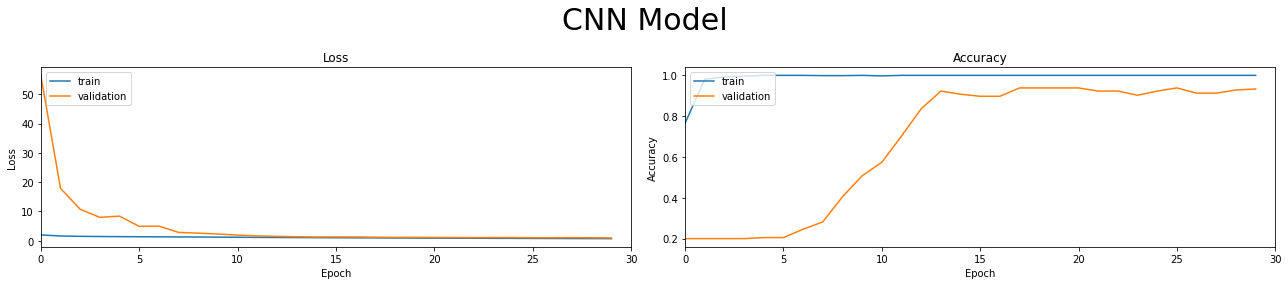

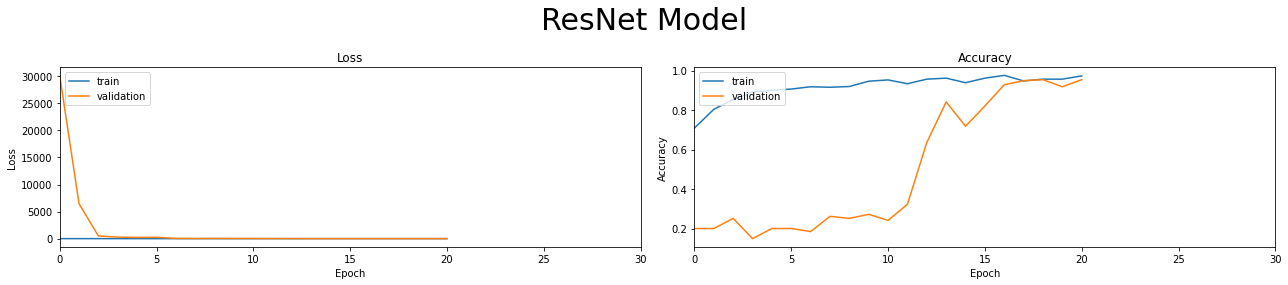

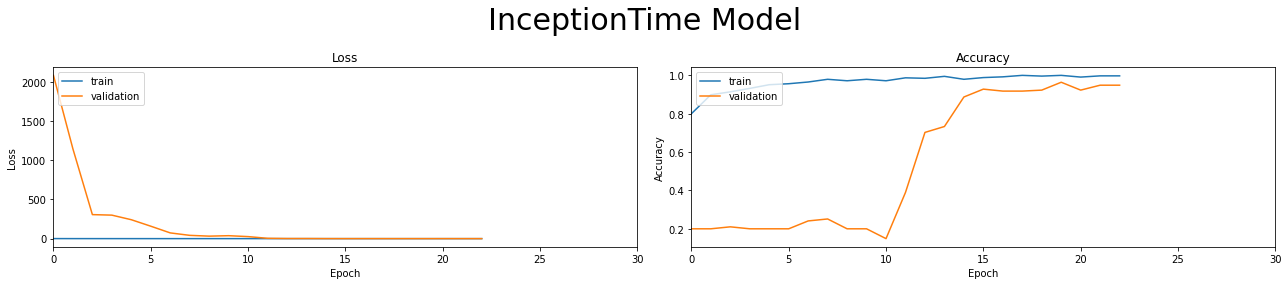

In [45]:
model_types = ['CNN', 'ResNet', 'InceptionTime']

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax1.set_xlim([0, 30])

    ax2.plot(history[i].history['accuracy'])
    ax2.plot(history[i].history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    ax2.set_xlim([0, 30])

    plt.tight_layout()
    plt.show()

## ResNet model evaluation

In [48]:
%%time

y_pred = best_model.predict(X_test, batch_size=1)

245/245 [==============================] - 2s 6ms/step
CPU times: total: 2.12 s
Wall time: 2.48 s


In [51]:
print("Classification report for the ResNet model:\n")
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

Classification report for the ResNet model:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.94      0.92      0.93        36
           2       1.00      0.96      0.98        53
           3       0.91      0.98      0.94        50
           4       0.92      0.90      0.91        52

    accuracy                           0.96       245
   macro avg       0.95      0.95      0.95       245
weighted avg       0.96      0.96      0.96       245



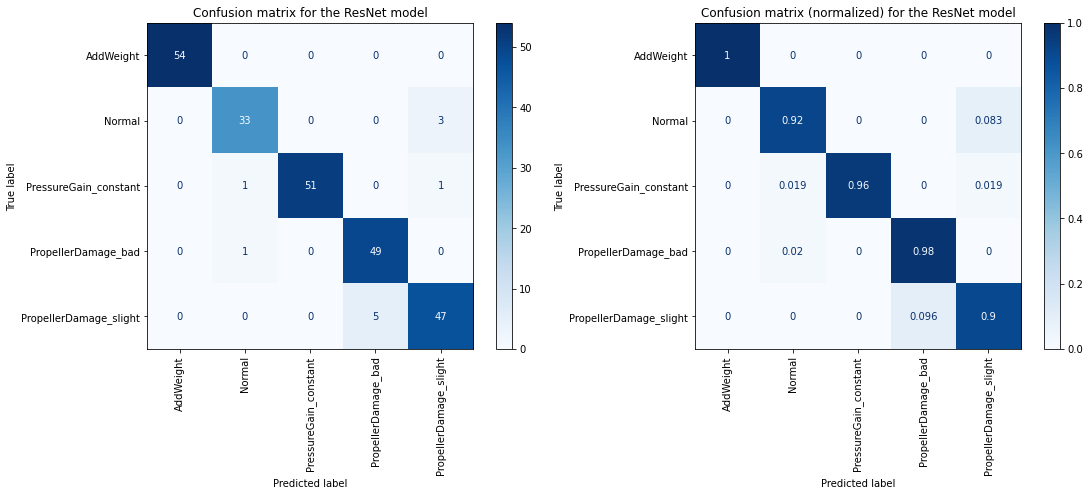

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    xticks_rotation="vertical",
    normalize=None,
    cmap="Blues",
    ax=ax1
)
ax1.set_title("Confusion matrix for the ResNet model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    xticks_rotation="vertical",
    normalize="true",
    cmap="Blues",
    ax=ax2
)
ax2.set_title("Confusion matrix (normalized) for the ResNet model")

plt.show()